In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-3t22fqt9
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-3t22fqt9
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a18b6b49af5314c904d62626d1a4ef7076554733_-cp36-none-any.whl size=96774 sha256=02a0f597ca722fba794740e397bdb44ebd82ad40797bfcc651a8180b79f9f3f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-13rixmgv/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [0]:
# Google tutorial on Image segmentation

%tensorflow_version 2.x

In [0]:
import numpy as np
import tensorflow as tf
# import matplotlib.pyplot as plt
# import tensorflow_datasets as tfds

# Tensorflow 2.0 has eager execution by default
# tf.compat.v1.enable_eager_execution()

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


In [0]:
dataset, info = tfds.load('oxford_iiit_pet:3.1.0', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteGB4S5C/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteGB4S5C/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0. Subsequent calls will reuse this data.


In [0]:
# pre processing operations
# normalize image data to [0, 1]
# labeled mask: {1, 2, 3} to {0, 1, 2}
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask
  

In [0]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 200 #10 * TRAIN_LENGTH // BATCH_SIZE

print('TRAIN_LENGHT:', TRAIN_LENGTH)
print('BATCH_SIZE:', BATCH_SIZE)
print('BUFFER_SIZE:', BUFFER_SIZE)
print('STEPS_PER_EPOCH:', STEPS_PER_EPOCH)

TRAIN_LENGHT: 3680
BATCH_SIZE: 32
BUFFER_SIZE: 1000
STEPS_PER_EPOCH: 200


In [0]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

print('train_dataset:', train_dataset)
print('test_dataset:', test_dataset)


train_dataset: <DatasetV1Adapter shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
test_dataset: <DatasetV1Adapter shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


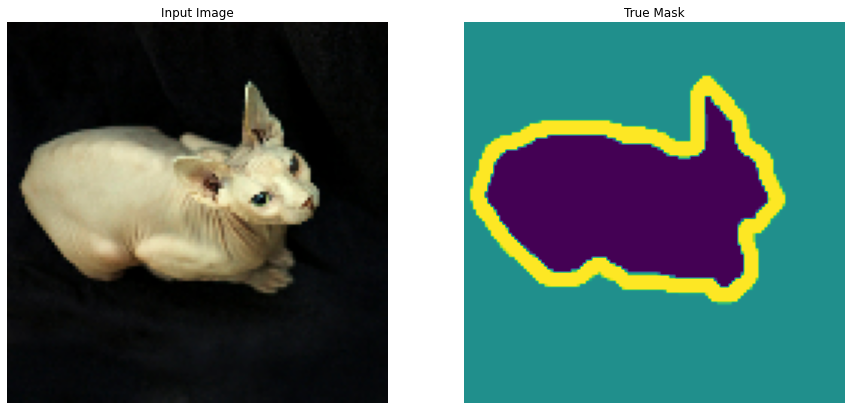

In [0]:
# show sample image from dataset
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [0]:
OUTPUT_CHANNELS = 3

def unet_model(input_size=(128, 128, 3), output_channels=3):
  inputs = tf.keras.layers.Input(input_size)
  n1_conv = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  n1_conv = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n1_conv)
  n1_pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(n1_conv)
  n2_conv = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n1_pool)
  n2_conv = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n2_conv)
  n2_pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(n2_conv)
  n3_conv = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n2_pool)
  n3_conv = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n3_conv)
  n3_pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(n3_conv)
  n4_conv = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n3_pool)
  n4_conv = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n4_conv)
  n4_drop = tf.keras.layers.Dropout(0.5)(n4_conv)
  n4_pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(n4_drop)

  n5_conv = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n4_pool)
  n5_conv = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n5_conv)
  n5_drop = tf.keras.layers.Dropout(0.5)(n5_conv)

  n6_conv   = tf.keras.layers.Conv2DTranspose(512, 2, strides = 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n5_drop)
  n6_concat = tf.keras.layers.concatenate([n4_drop, n6_conv], axis = 3)
  n6_conv   = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n6_concat)
  n6_conv   = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n6_conv)

  n7_conv   = tf.keras.layers.Conv2DTranspose(256, 2, strides = 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n6_conv)
  n7_concat = tf.keras.layers.concatenate([n3_conv, n7_conv], axis = 3)
  n7_conv   = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n7_concat)
  n7_conv   = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n7_conv)

  n8_conv   = tf.keras.layers.Conv2DTranspose(128, 2, strides = 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n7_conv)
  n8_concat = tf.keras.layers.concatenate([n2_conv,n8_conv], axis = 3)
  n8_conv   = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n8_conv)
  n8_conv   = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n8_conv)

  n9_conv   = tf.keras.layers.Conv2DTranspose(64, 2, strides = 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n8_conv)
  n9_concat = tf.keras.layers.concatenate([n1_conv,n9_conv], axis = 3)
  n9_conv   = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n9_concat)
  n9_conv   = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n9_conv)
  n10_conv  = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 1, activation = 'softmax')(n9_conv)

  return tf.keras.Model(inputs=inputs, outputs=n10_conv)

input_shape = [128, 128, 3]
model = unet_model(input_shape, OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

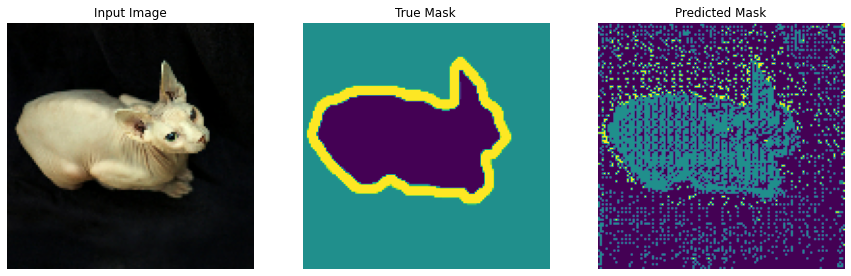

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

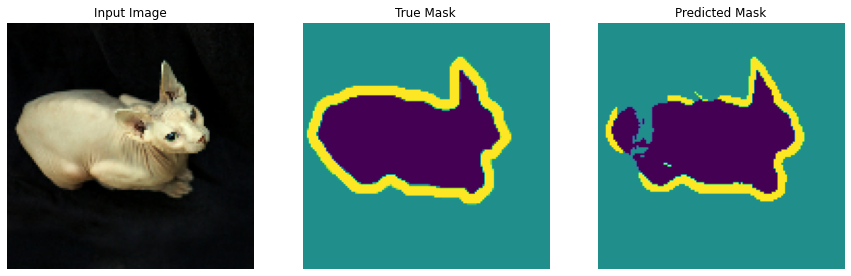


Sample Prediction after epoch 10

200/200 [==============================] - 94s 472ms/step - loss: 0.2410 - accuracy: 0.8992 - val_loss: 0.3137 - val_accuracy: 0.8763


In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

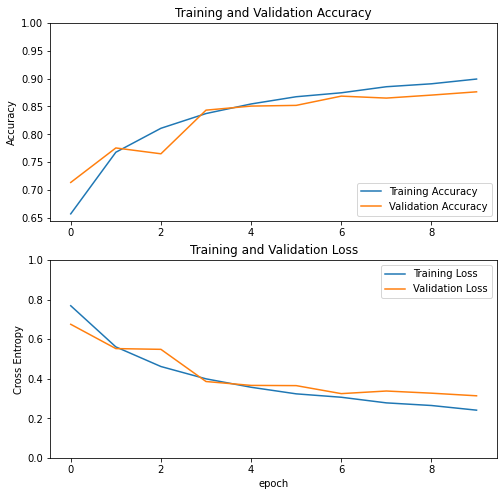

In [0]:
# Learning curves
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
# Evaluate the model
test_steps = 20
test_loss, test_accuracy = model.evaluate(test_dataset, steps = test_steps)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}".format(test_accuracy))

20/20 [==============================] - 3s 158ms/step - loss: 0.3162 - accuracy: 0.8755
Test loss: 0.32
Test accuracy: 0.88


In [0]:
# Convert Keras model to TF Lite format.
print(tf.__version__)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

2.2.0-rc1
Float model size = 120653KBs.


In [0]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 38352KBs,
which is about 31% of the float model size.


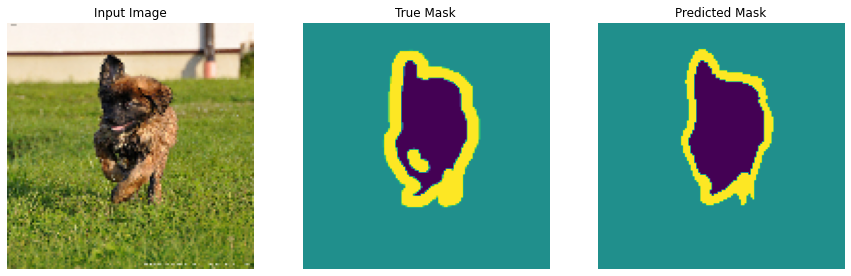

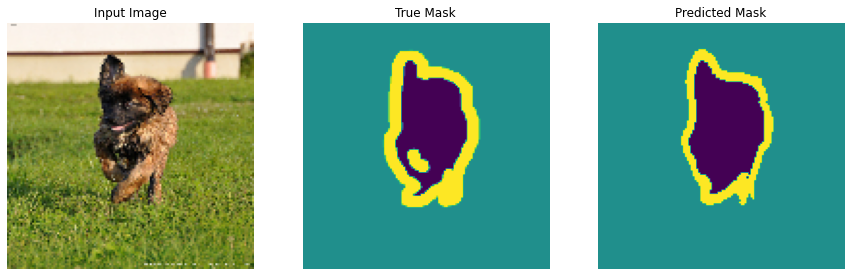

In [0]:
import random

test_images = test.batch(1)

def show_model_predictions(tflite_model, dataset=test_images, num=1):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  prediction_image = []
  # Run predictions on every image in the "test" dataset.
  for test_image, test_label in dataset.take(1):
    # Pre-processing: add batch dimension to match with
    # the model's input data format.
    # test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    # print(test_image)
    # print(test_label)
    # test_image = test_image.astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)
    # Run inference.
    interpreter.invoke()
    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    prediction_image.append(output())

  if len(prediction_image) == 0:
    print('No prediction found!')
  else:
    for image, mask in dataset.take(1):
      pred_mask = prediction_image[0]
      display([image[0], mask[0], create_mask(pred_mask)])


# float model prediction
show_model_predictions(tflite_float_model)

# quantized model prediction
show_model_predictions(tflite_quantized_model)

In [0]:
# Save the float model to file to the Downloads directory
f = open('/content/drive/My Drive/DeepGC/UNet/myUNet_float.tflite', "wb")
f.write(tflite_float_model)
f.close()

# Save the quantized model to file to the Downloads directory
f = open('/content/drive/My Drive/DeepGC/UNet/myUNet_quant.tflite', "wb")
f.write(tflite_quantized_model)
f.close()